# Recurrence Flow example

<font size="4"> 
We demonstrate the validity of the provided subroutines by reproducing the ENSO example from the paper and show another example for identifying lagged nonlinear correlations between a pair of time series.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl

# module for numerical integration of DDE
from ddeint import ddeint

# import the module
import recflow as rf

<font size="4"> 
ENSO delay differential equation:

In [6]:
def values_before_zero(t):
    return 1
def ENSO_DDE(Y, t):
    return -np.tanh(k*Y(t-tau1)) + b*np.cos(2*np.pi*t)

## Delay selection

<font size="4"> 
For the sake of computational speed, we only generate a very short time series that roughly covers 2.5 big cycles. Red dots indicate the cycle that corresponds to the first selected embedding delay, green dots correspond to the second one.

Text(0.5, 0, 'time')

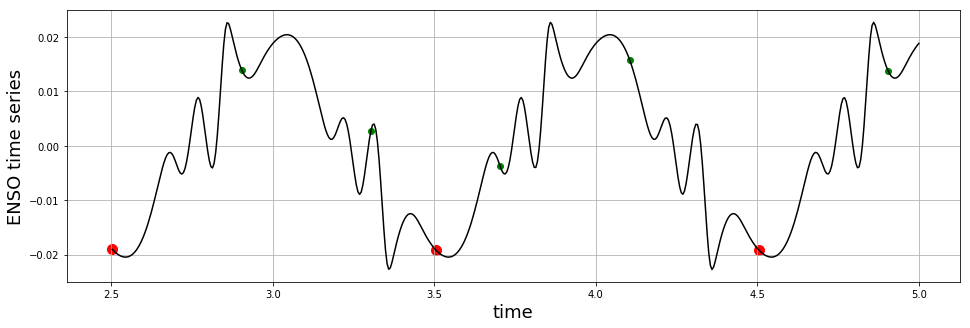

In [7]:
# Generate short ENSO time series
k = 100; b = 1; tau1 = 0.025
a_t = np.linspace(0, 5, 1000)
yy = ddeint(ENSO_DDE, values_before_zero, a_t)
a_ts = np.hstack(yy[500:])
delta = np.diff(a_t)[0]

# PLOT
fig = plt.figure(figsize=(16, 5))
plt.grid()
plt.plot(a_t[500:], a_ts, color='black')
plt.scatter(a_t[500:][::(20*4)], a_ts[::(20*4)], color='green')
plt.scatter(a_t[500:][::(50*4)], a_ts[::(50*4)], color='red', s=100)
plt.ylabel('ENSO time series', fontsize=18); plt.xlabel('time', fontsize=18)

<font size="4"> 
Next, we specify a 3D-embedding and select the two embedding delays that maximize the resulting recurrence flow. This shouldn't take longer than a few seconds up to a minute.

In [12]:
# parameters
a_delays = np.arange(1, 100, 1)
rr = 0.06

# Recurrence Flow
a_flow, l_tau = rf.recflow_embed(a_ts, 3, a_delays, rr, None)
print('The optimal selection of delays is given by: ' + str(l_tau))

The optimal selection of delays is given by: [0, 50, 20]


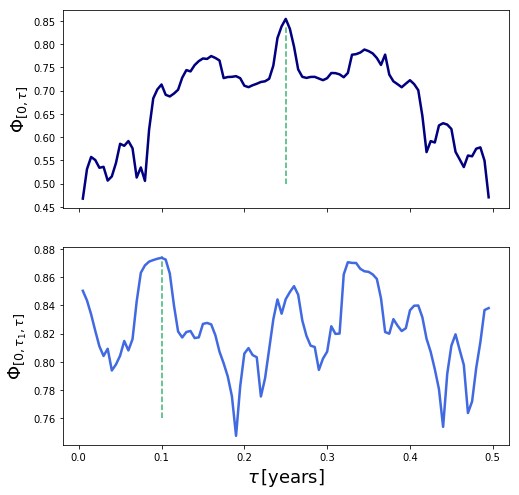

In [14]:
## PLOT
fig, ax = plt.subplots(nrows=2, figsize=(14,12))
ax[0].plot(a_delays, a_flow[0,].T, color='navy', linewidth=2.5, zorder=2)
ax[0].set_ylabel(r'$\Phi_{[0,\tau]}$', fontsize=18); 
ax[0].set_xticks(np.arange(0, a_delays[-1]+20, 20)); 
ax[0].set_xticklabels([])
ax[0].vlines(l_tau[1], 0.5, 0.84, linestyle='dashed', color='mediumseagreen')
ax[1].plot(a_delays, a_flow[1,].T, color='royalblue', linewidth=2.5, zorder=2)
ax[1].set_ylabel(r'$\Phi_{[0,\tau_1,\tau]}$', fontsize=18)
ax[1].set_xlabel(r'$\tau \,[\mathrm{years}]$', fontsize=18)
ax[1].set_xticks(np.arange(0, a_delays[-1]+20, 20));
ax[1].set_xticklabels(np.round(np.arange(0, a_delays[-1]+20, 20)*delta,2))
ax[1].vlines(l_tau[2], 0.76, 0.875, linestyle='dashed', color='mediumseagreen')
fig.set_size_inches(8, 8)

### State space

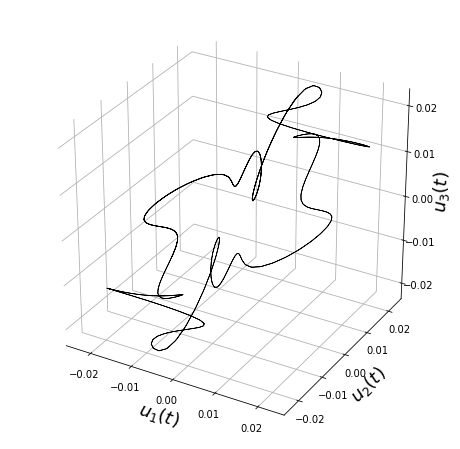

In [16]:
tmp_traj = rf.TDE(a_ts, l_tau[:3], [0,0, 0])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(tmp_traj[:,0], tmp_traj[:,1], tmp_traj[:,2], color='black', linewidth=.75)
ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w'); ax.yaxis.pane.set_edgecolor('w'); ax.zaxis.pane.set_edgecolor('w')
ax.set_xlabel('$u_1(t)$', fontsize=18); ax.set_ylabel('$u_2(t)$', fontsize=18); ax.set_zlabel('$u_3(t)$', fontsize=18)
fig.set_size_inches(8, 8)

### Recurrence plot

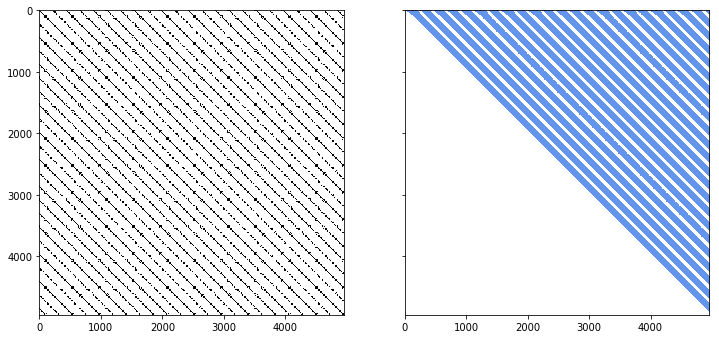

In [28]:
# compute RP for 3D embedding
a_rp = rf.RP(a_ts, l_tau, [0,0,0], rr, theiler=None)
# flood RP and return flow matrix
a_flood = rf.floodRP(a_rp, return_flowmat=True)

# PLOT
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
cmap = mpl.colors.ListedColormap(['white', 'cornflowerblue'])
norm = mpl.colors.BoundaryNorm([0, 1, 2], cmap.N)
ax[0].imshow(a_rp, origin='lower', cmap='binary')
ax[1].imshow(a_flood,  cmap=cmap, norm=norm)
fig.set_size_inches(12, 12)

## Recurrence Flow Measure of Dependence

<font size="4"> 
We generate a pair of time series similar to fig. 2 in the paper, but based on the ENSO DDE model.
The resulting dependence structure is highly nonlinear (and basically looks like an uterus).

In [17]:
T = 5000
def rescale_range(arr, newmin, newmax):
    a_rescld = np.interp(arr, (arr.min(), arr.max()), (newmin, newmax))
    return a_rescld

# Generate NESO time series
a_t = np.linspace(0, 25, T+500)
delta = np.diff(a_t)[0]
k = 100; b = 1; tau1 = 0.025
yy = ddeint(ENSO_DDE, values_before_zero, a_t)
a_ts = np.hstack(yy[500:])

# Apply noise, rescaling and lag to obtain pair of x and y time series
lag = 10
a_x = rescale_range(a_ts + np.random.normal(0, .001, T), -5, 5)
a_y = -0.1*(a_x[lag:]**2 + np.random.normal(0, 0.1*a_x.std(), T-lag))
a_x = a_x[:-lag]

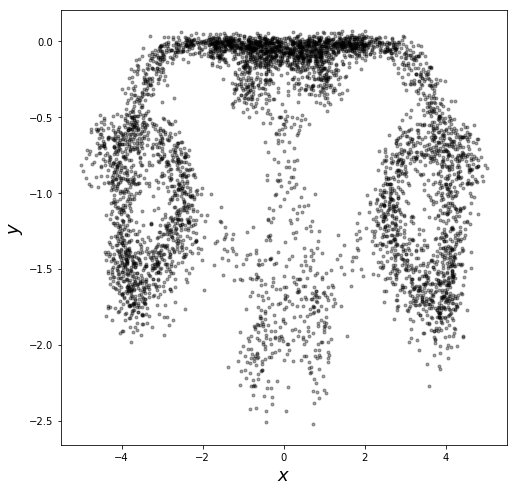

In [18]:
## PLOT
fig = plt.figure()
plt.scatter(a_x, a_y, color='black', alpha=.35, marker='.')
plt.xlabel('$x$', fontsize=18); plt.ylabel('$y$', fontsize=18)
fig.set_size_inches(8, 8)

<font size="4"> 
Computation of the recurrence flow measure of dependence shows a pronounced peak (and in fact the global flow maximum) at the defined lag between $x$ and $y$. Additional local maxima probably correspond to multiples of the sum of this lag and the time series period lengths. This can take a few minutes to compute.

In [19]:
a_delays = np.arange(0, 201, 1)
rr = .1
a_rmfd = rf.RFMD(x=a_x, y=a_y, delays=a_delays, rr=rr, theiler=None)

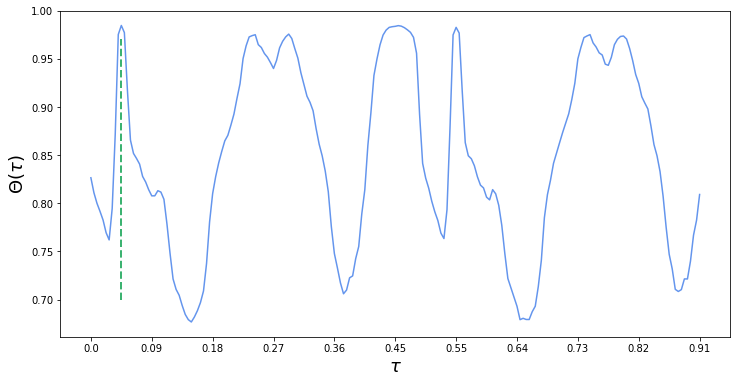

In [20]:
## PLOT
fig = plt.figure()
plt.plot(a_delays, a_rmfd, color='cornflowerblue')
plt.vlines(lag, 0.7, 0.97, color='mediumseagreen', linewidth=2, linestyle='dashed')
plt.ylabel(r'$\Theta(\tau)$', fontsize=18); plt.xlabel(r'$\tau$', fontsize=18)
plt.xticks(np.arange(0, a_delays[-1]+20, 20), labels=np.round(np.arange(0, a_delays[-1]+20, 20)*delta,2))
fig.set_size_inches(12, 6)